In [41]:
import utils
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [42]:
# Load the Dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

y_train_valid -= 769
y_test -= 769


(2115, 22, 1000)


In [43]:
# Optimize a classifier for just one subject, and see how well this 
# classifier can generalize to all subjects

subject_train_X_valids = []
subject_train_y_valids = []
subject_X_tests = []
subject_y_tests = []

for i in range(9):
  train_valid_indices = np.where(person_train_valid[:, 0] == i)
  test_indices = np.where(person_test[:, 0] == i)

  subject_train_X_valids.append(X_train_valid[train_valid_indices])
  subject_train_y_valids.append(y_train_valid[train_valid_indices])
  subject_X_tests.append(X_test[test_indices])
  subject_y_tests.append(y_test[test_indices])


print(subject_train_X_valids[0].shape)
print(subject_X_tests[0].shape)


(237, 22, 1000)
(50, 22, 1000)


In [44]:
# Prepare data for training
subject_X_trains = []
subject_y_trains = []
subject_X_valids = []
subject_y_valids = []

for i in range(9):
  ind_valid = np.random.choice(subject_train_X_valids[i].shape[0], 40, replace=False)
  ind_train = np.array(list(set(range(subject_train_X_valids[i].shape[0])).difference(set(ind_valid))))
  x_train = subject_train_X_valids[i][ind_train]
  y_train = subject_train_y_valids[i][ind_train]
  x_valid = subject_train_X_valids[i][ind_valid]
  y_valid = subject_train_y_valids[i][ind_valid]

  x_train, y_train = utils.addNoisyExamplesToData(x_train, y_train, 2000, 0, 1)

  indices = np.random.permutation(len(x_train))
  x_train = x_train[indices]
  y_train = y_train[indices]

  y_train = to_categorical(y_train, 4)
  y_valid = to_categorical(y_valid, 4)
  subject_y_tests[i] = to_categorical(subject_y_tests[i], 4)

  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
  x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1)
  subject_X_tests[i] = subject_X_tests[i].reshape(subject_X_tests[i].shape[0], subject_X_tests[i].shape[1], subject_X_tests[i].shape[2], 1)

  # Axis swapping
  x_train = np.swapaxes(x_train, 1, 3)
  x_train = np.swapaxes(x_train, 1, 2)
  x_valid = np.swapaxes(x_valid, 1, 3)
  x_valid = np.swapaxes(x_valid, 1, 2)
  subject_X_tests[i] = np.swapaxes(subject_X_tests[i], 1, 3)
  subject_X_tests[i] = np.swapaxes(subject_X_tests[i], 1, 2)

  subject_X_trains.append(x_train)
  subject_y_trains.append(y_train)
  subject_X_valids.append(x_valid)
  subject_y_valids.append(y_valid)

In [45]:
models = []

for i in range(9):
  cnn_model = Sequential()

  # Given that this is time-series data, having a kernel that is more along one dimension (e.g. 15 by 1) is reasonable
  # since there is not really much of a relationship between "square" tiles of the data but rather subsequent 
  # tiles
  cnn_model.add(Conv2D(filters=10, kernel_size=(15, 1), padding='same', activation='relu', input_shape=(1000, 1, 22)))
  cnn_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(0.5))

  cnn_model.add(Conv2D(filters=20, kernel_size=(10, 1), padding='same', activation='relu'))
  cnn_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(0.5))

  cnn_model.add(Conv2D(filters=40, kernel_size=(5, 1), padding='same', activation='relu'))
  cnn_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(0.5))

  cnn_model.add(Conv2D(filters=60, kernel_size=(5, 1), padding='same', activation='relu'))
  cnn_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(0.5))

  cnn_model.add(Flatten())
  cnn_model.add(Dense(4, activation='softmax'))

  models.append(cnn_model)


In [46]:
learning_rate = 1e-3
epochs = 50
cnn_model_optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)

In [47]:
results = []

for i in range(9):
  print("Model {num}".format(num = i + 1))
  # Compiling the model
  models[i].compile(loss='categorical_crossentropy',
                  optimizer=cnn_model_optimizer,
                  metrics=['accuracy'])

  # Training and validating the model
  cnn_model_results = models[i].fit(subject_X_trains[i],
              subject_y_trains[i],
              batch_size=64,
              epochs=epochs,
              validation_data=(subject_X_valids[i], subject_y_valids[i]), verbose=True)
  results.append(cnn_model_results)

Model 1
Epoch 1/50
35/35 [==============================] - 1s 30ms/step - loss: 2.0508 - accuracy: 0.3081 - val_loss: 2.7360 - val_accuracy: 0.2750
Epoch 2/50
35/35 [==============================] - 1s 27ms/step - loss: 1.6464 - accuracy: 0.3887 - val_loss: 1.4354 - val_accuracy: 0.3750
Epoch 3/50
35/35 [==============================] - 1s 26ms/step - loss: 1.4831 - accuracy: 0.4233 - val_loss: 1.1600 - val_accuracy: 0.6000
Epoch 4/50
35/35 [==============================] - 1s 26ms/step - loss: 1.2155 - accuracy: 0.5098 - val_loss: 1.2438 - val_accuracy: 0.3000
Epoch 5/50
35/35 [==============================] - 1s 33ms/step - loss: 0.9770 - accuracy: 0.5949 - val_loss: 1.5269 - val_accuracy: 0.3250
Epoch 6/50
35/35 [==============================] - 1s 26ms/step - loss: 0.8491 - accuracy: 0.6413 - val_loss: 1.4868 - val_accuracy: 0.4000
Epoch 7/50
35/35 [==============================] - 1s 27ms/step - loss: 0.7488 - accuracy: 0.6764 - val_loss: 1.6159 - val_accuracy: 0.3750
Epoch

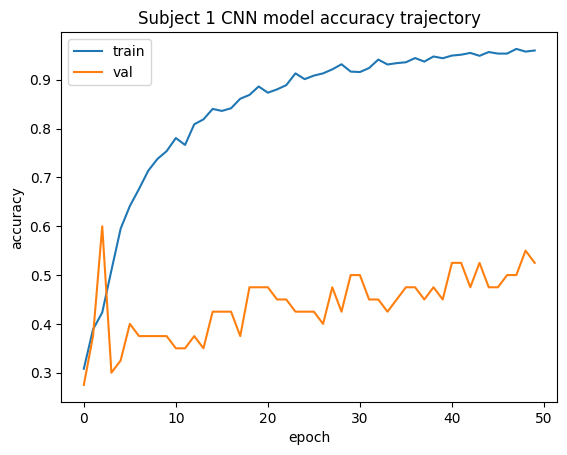

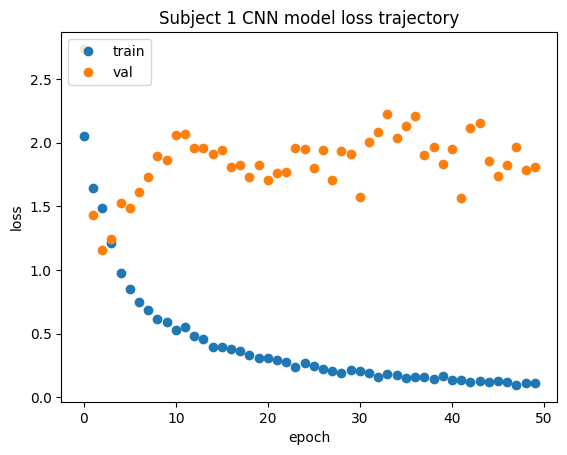

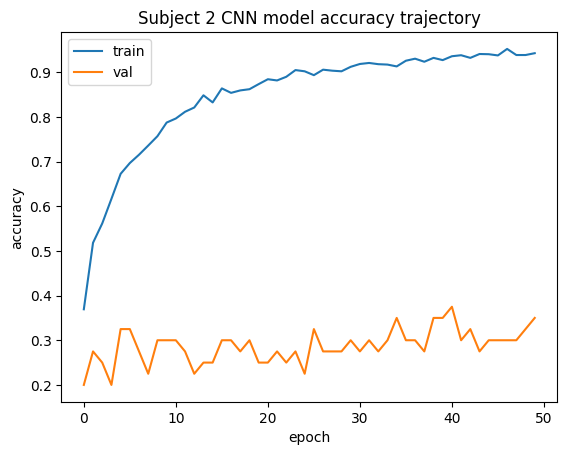

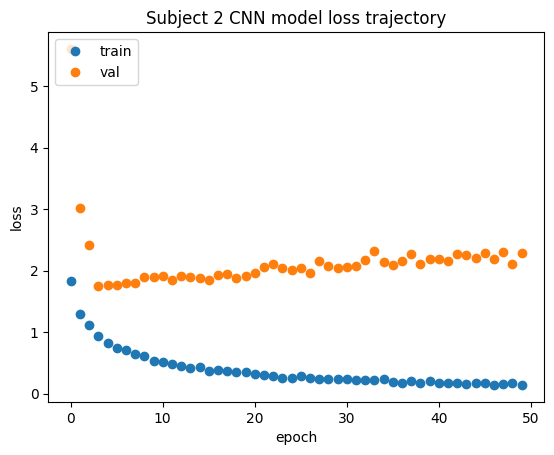

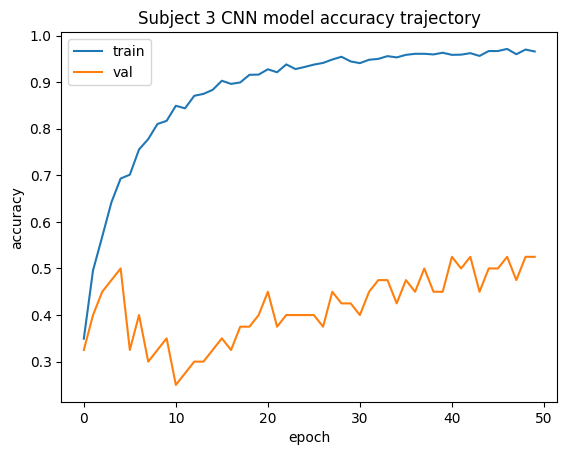

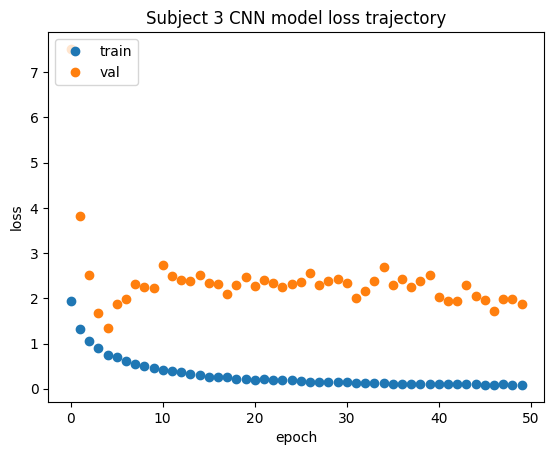

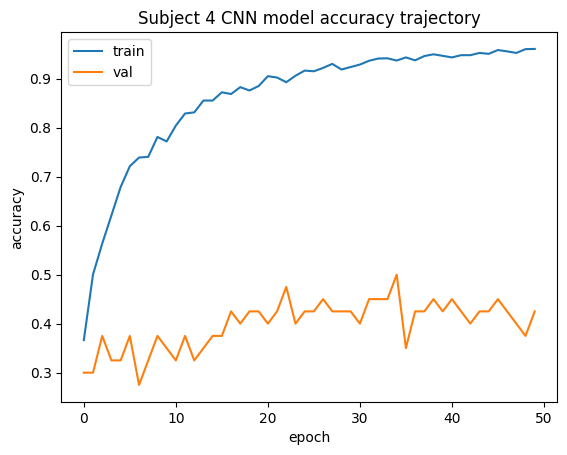

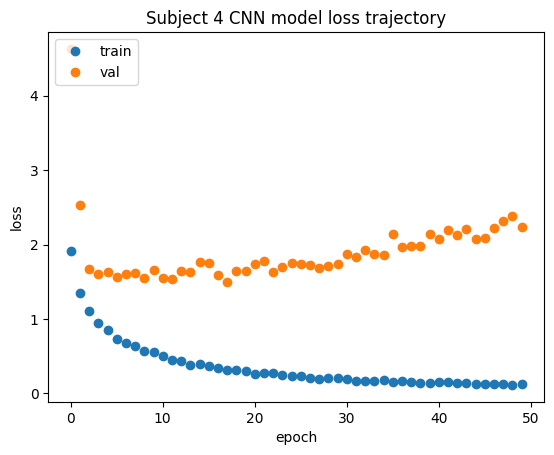

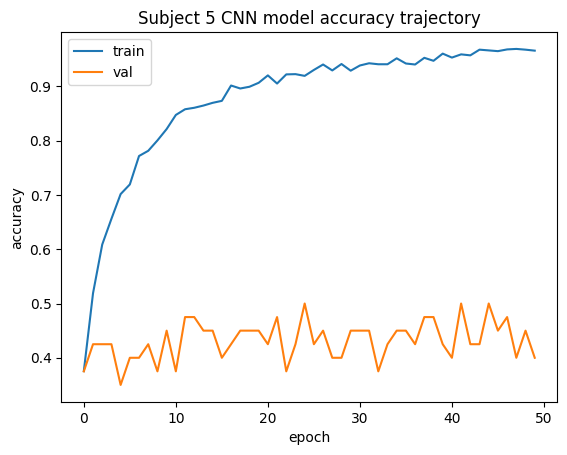

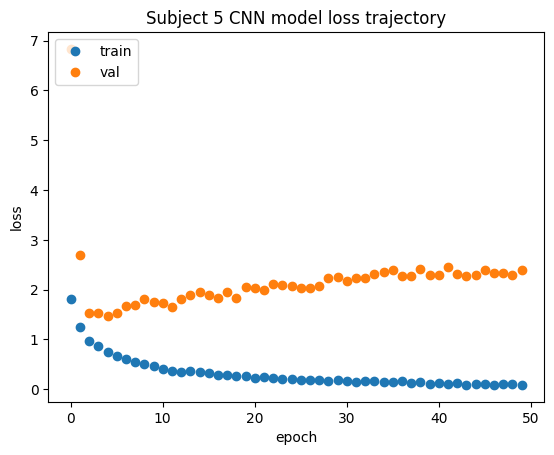

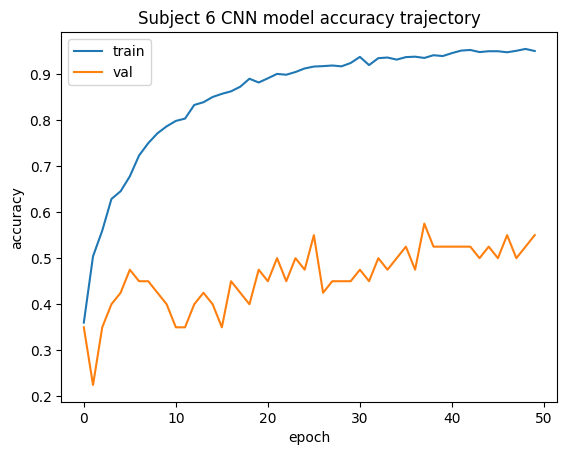

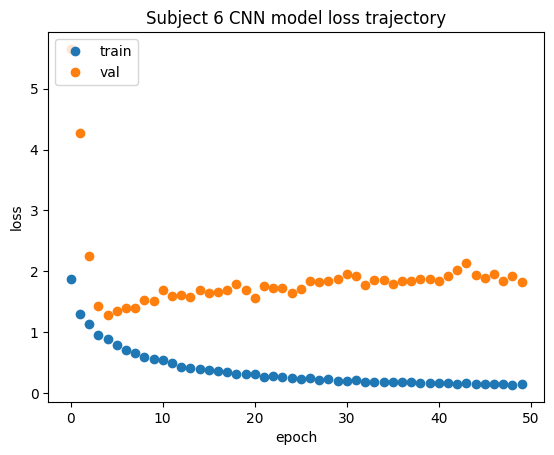

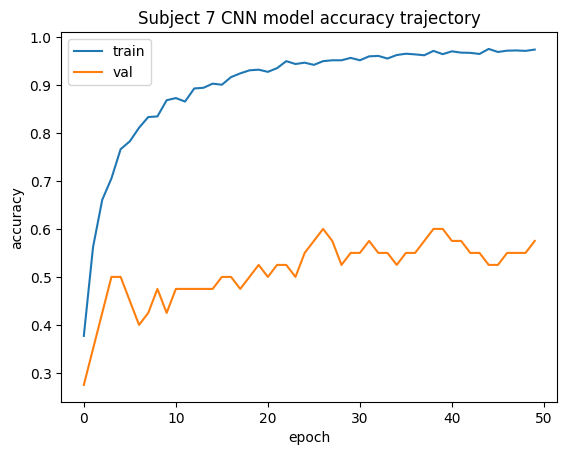

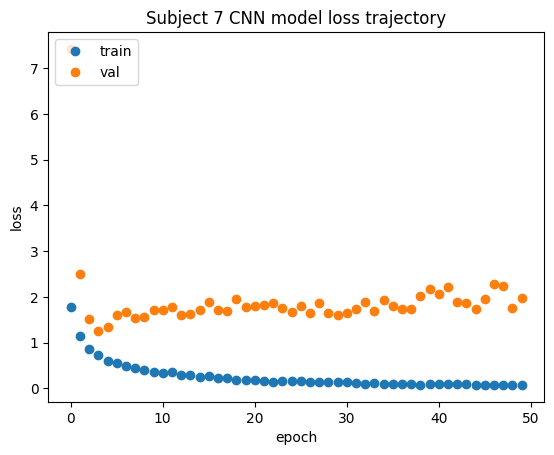

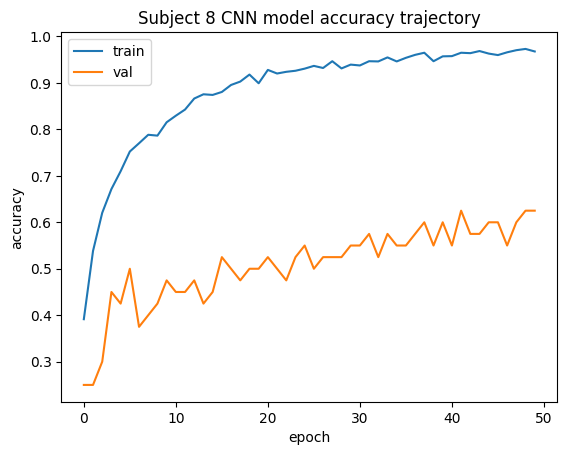

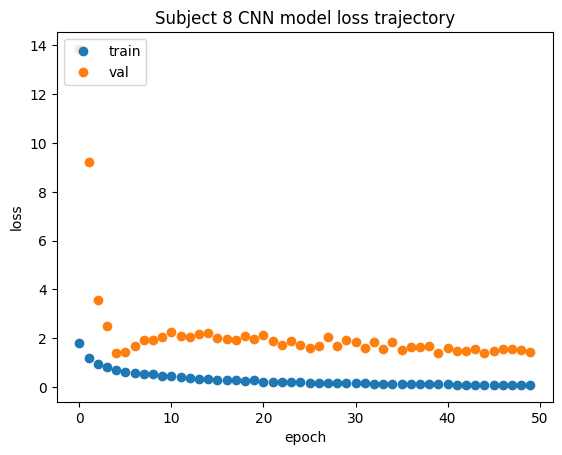

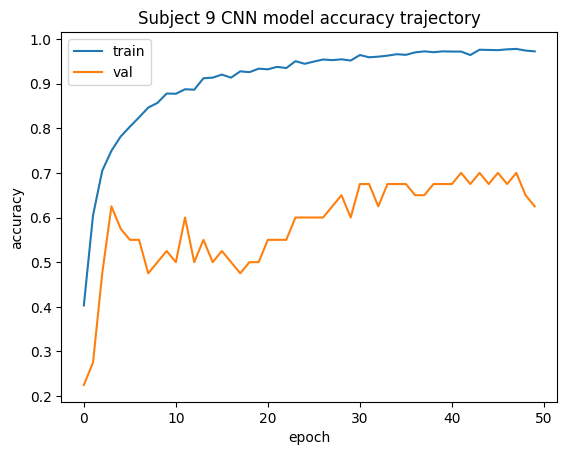

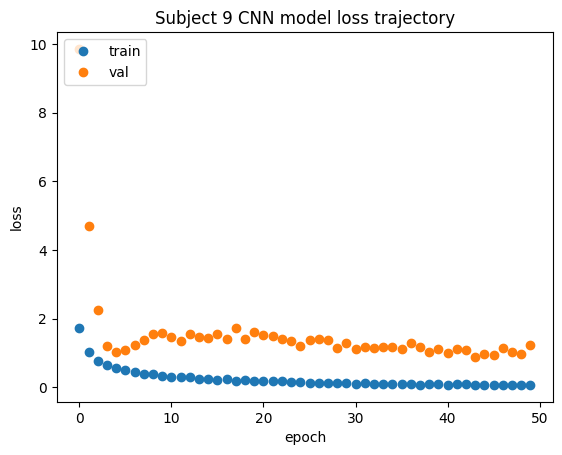

In [48]:
for i in range(9):
  plt.figure()

  # Plotting accuracy trajectory
  plt.plot(results[i].history['accuracy'])
  plt.plot(results[i].history['val_accuracy'])
  plt.title('Subject {num} CNN model accuracy trajectory'.format(num = i + 1))
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  # Plotting loss trajectory
  plt.plot(results[i].history['loss'],'o')
  plt.plot(results[i].history['val_loss'],'o')
  plt.title('Subject {num} CNN model loss trajectory'.format(num = i + 1))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [50]:
# Test each individual model over testing for that specific subject
for i in range(9):
  score = models[i].evaluate(subject_X_tests[i], subject_y_tests[i], verbose=0)
  print("Subject {num} Accuracy: {score}".format(num = i + 1, score=score[1]))

Subject 1 Accuracy: 0.47999998927116394
Subject 2 Accuracy: 0.36000001430511475
Subject 3 Accuracy: 0.5799999833106995
Subject 4 Accuracy: 0.41999998688697815
Subject 5 Accuracy: 0.5957446694374084
Subject 6 Accuracy: 0.44897958636283875
Subject 7 Accuracy: 0.6600000262260437
Subject 8 Accuracy: 0.5199999809265137
Subject 9 Accuracy: 0.6170212626457214


In [62]:
# Test the model against all other subjects
for i in range(9):
  test_x = None
  test_y = None
  for j in range(9):
    if j == i:
      continue
    if test_x is None:
      test_x = np.copy(subject_X_tests[j])
      test_y = np.copy(subject_y_tests[j])
    else:
      test_x = np.vstack((test_x, subject_X_tests[j]))
      test_y = np.vstack((test_y, subject_y_tests[j]))
    
  
  score = models[i].evaluate(test_x, test_y, verbose=0)
  print("Subject {num} Cross-Subject Test Accuracy: {score}".format(num = i + 1, score=score[1]))

Subject 1 Cross-Subject Test Accuracy: 0.3765903413295746
Subject 2 Cross-Subject Test Accuracy: 0.29262086749076843
Subject 3 Cross-Subject Test Accuracy: 0.31552162766456604
Subject 4 Cross-Subject Test Accuracy: 0.32569974660873413
Subject 5 Cross-Subject Test Accuracy: 0.3484848439693451
Subject 6 Cross-Subject Test Accuracy: 0.2664974629878998
Subject 7 Cross-Subject Test Accuracy: 0.3638676702976227
Subject 8 Cross-Subject Test Accuracy: 0.3435114622116089
Subject 9 Cross-Subject Test Accuracy: 0.3181818127632141


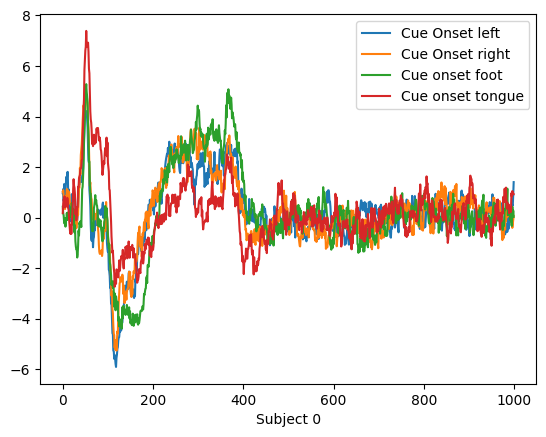

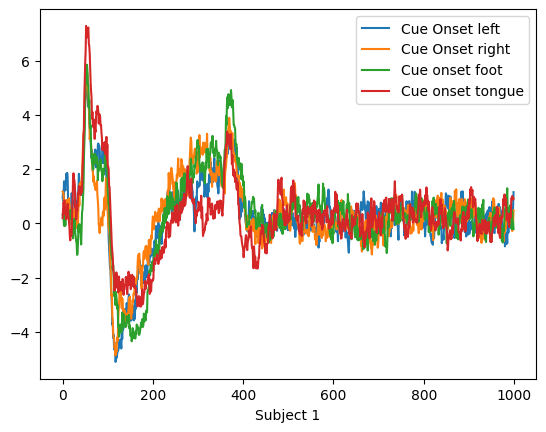

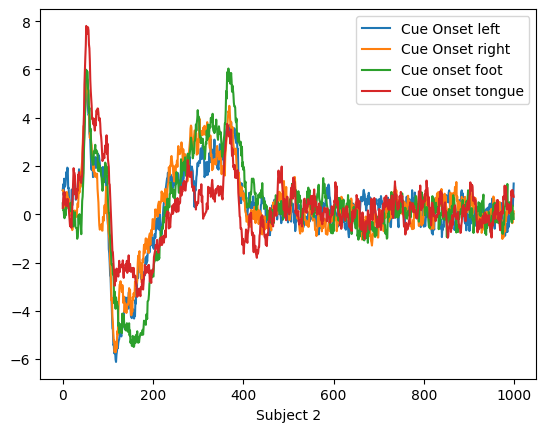

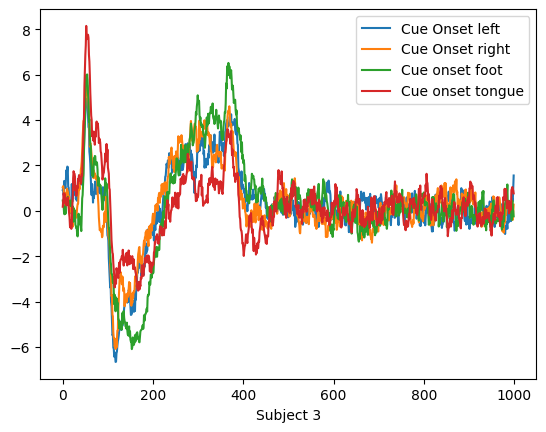

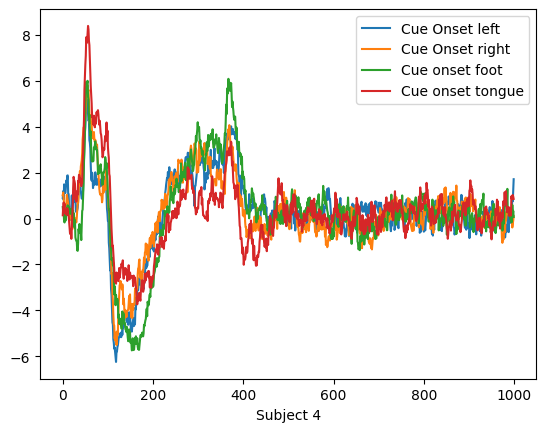

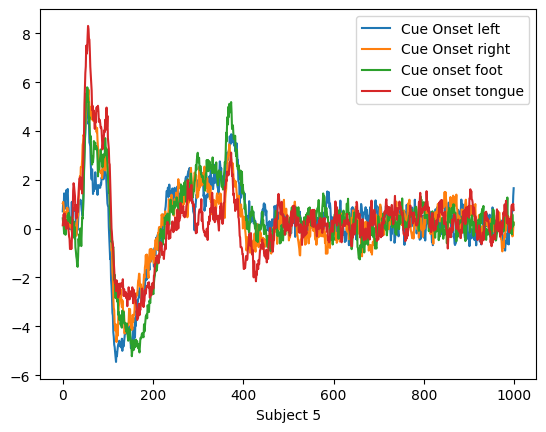

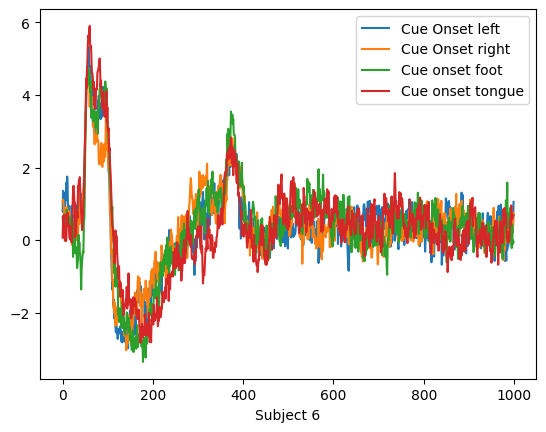

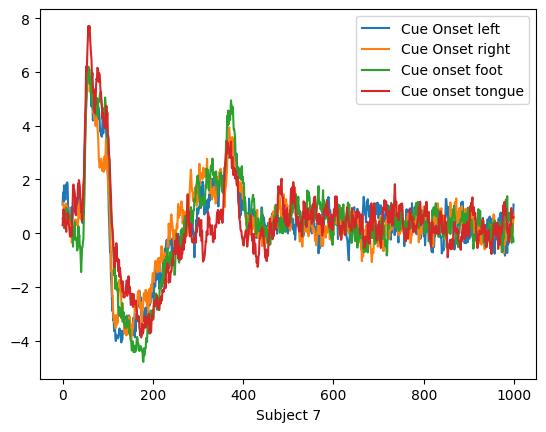

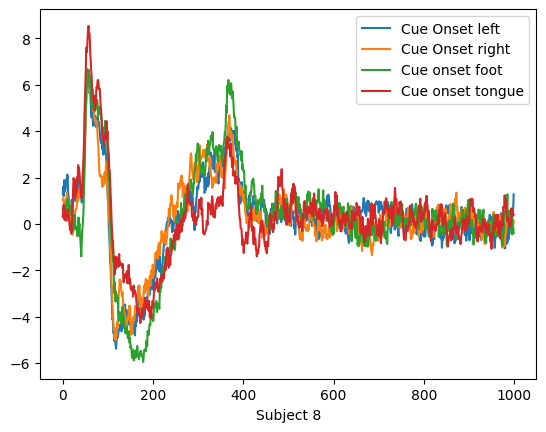

In [28]:
for i in range(9):
  ch_data = X_train_valid[:,i,:]


  class_0_ind = np.where(y_train_valid == 0)
  ch_data_class_0 = ch_data[class_0_ind]
  avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


  class_1_ind = np.where(y_train_valid == 1)
  ch_data_class_1 = ch_data[class_1_ind]
  avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

  class_2_ind = np.where(y_train_valid == 2)
  ch_data_class_2 = ch_data[class_2_ind]
  avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

  class_3_ind = np.where(y_train_valid == 3)
  ch_data_class_3 = ch_data[class_3_ind]
  avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)

  plt.figure()
  plt.plot(np.arange(1000),avg_ch_data_class_0)
  plt.plot(np.arange(1000),avg_ch_data_class_1)
  plt.plot(np.arange(1000),avg_ch_data_class_2)
  plt.plot(np.arange(1000),avg_ch_data_class_3)
  plt.xlabel("Subject {subject}".format(subject=i))

  plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])